## PARQUETS
- Since the dataset is too large,
- We can use PySpark to convert the file to parquets
- After this we can use pandas to read the Parquets
    - Parquets are easier and faster to read
    - Parquets easily allow for Parallel procesing
    

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q pyspark
# !pip install -q handyspark
# !pip install category_encoders
# from convert_to_pq import convert_multiple_files_to_parquet
# convert_multiple_files_to_parquet('./Project Data/')

In [ ]:
import warnings
warnings.simplefilter('ignore')
import gc
from pyspark.sql.functions import from_unixtime, unix_timestamp, col, sum, dayofweek, dayofmonth, hour
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.executor.memory", "4g").config("spark.dynamicAllocation.enabled", "true").appName("Modelling").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [ ]:
df = spark.read.options( header=False, inferschema=True).load('/kaggle/input/ai-and-ml-project/parquets/ProjectTrainingData/', format='parquet')

### Large Data
- The train set is too big to work with all at once.
- We decided to split it in to 5% potions.
- we randomly sample the data into 20 portions.
- We will keep sampling some of these pportions at different stages

In [ ]:
num_train_splits = 20
fraction = 1/num_train_splits
for i in range(num_train_splits):
    df_sample = df.sample(fraction = fraction)
    df_sample.write.parquet(f'/kaggle/working/parquets/TrainingData-{i}', mode='overwrite')
    del df_sample
    gc.collect()

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from numpy.random import randint

del df
spark.stop()
gc.collect()

7

In [11]:
rand_ = randint(0, num_train_splits)
df = pd.read_parquet(f"/kaggle/working/parquets/TrainingData-{rand_}/")
def format_date(df):
    df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H') 
    df.sort_values(by='hour', ascending=True, inplace=True)
    df['week_day'] = df.hour.dt.day_of_week
    df['month_day'] = df.hour.dt.day
    df['time_of_day'] = df.hour.dt.hour
    lenn = len(df)
    return df
       
df = format_date(df)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,week_day,month_day,time_of_day
1292404,18180214171850133249,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,2e752044,779d90c2,1,0,15702,320,50,1722,0,35,100084,79,1,21,0
1292045,17111231312015791772,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,54fa7ff7,6ce25010,1,0,20352,320,50,2333,0,39,-1,157,1,21,0
1292046,17114503793083793991,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,57d5df04,d787e91b,1,0,15705,320,50,1722,0,35,100084,79,1,21,0
1292047,17116761638300395268,0,2014-10-21,1005,1,22d080df,6eb534a7,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,ae42194b,900981af,1,2,18993,320,50,2161,0,35,-1,157,1,21,0
1292048,17117289421826349399,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1db2bef1,553f099b,1,0,15708,320,50,1722,0,35,100084,79,1,21,0


In [12]:
# splitting the data into train, validation and test sets split into 60, 20, 20 splits
# since this is a time series dataset, we split based on time to avoid data leakage
# we convert the hour column to datetime, and sort and split the data based on it
cols_to_calculate = ['time_of_day', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 
                     'app_category', 'device_id', 'device_model', 'C14', 'C17', 'C19', 'C20', 'C21']
def compute_ctr(train,val, cols_to_calculate=cols_to_calculate):
    for col in cols_to_calculate:
        ctr_col = train.groupby(col, as_index=False)['click'].mean()
        ctr_col.columns = [col,f'{col}_ctr']
        train = pd.merge(train, ctr_col, how='left', )
        val = pd.merge(val, ctr_col, how='left', )
    return train, val
def compute_ctr_train_val(dt, cols_to_calculate=cols_to_calculate):
    lenn = len(dt)
    train_size, val_size = int(0.7*lenn), int(0.3*lenn)
    train, val = dt.iloc[:train_size,],dt.iloc[train_size:,]
    print(f"Train size: {len(train):,}   Val size: {len(val):,}")
    train, val = compute_ctr(train, val)
    return train, val
    

train, val = compute_ctr_train_val(df)

del df
gc.collect()

Train size: 1,120,471   Val size: 480,203


20

In [13]:
def split_train_val(train_dt, val_dt):
    train_dt = train_dt.drop(cols_to_calculate, axis=1)
    train_dt = train_dt.drop(['id', 'hour', 'device_ip'], axis=1)
    val_dt = val_dt.drop(cols_to_calculate, axis=1)
    val_dt = val_dt.drop(['id', 'hour', 'device_ip'], axis=1)
    train_dt = train_dt.fillna(0)
    val_dt = val_dt.fillna(0)
    trainX, trainY = train_dt.drop('click', axis=1), train_dt['click']
    print(f"Trainig shape::  X: {trainX.shape}, Y: {trainY.shape}")
    try:
        valX, valY = val_dt.drop('click', axis=1), val_dt['click']
        print(f"Validation shape::  X:{valX.shape}, Y: {valY.shape}")
        del train_dt
        del val_dt
        gc.collect()
        return trainX, trainY, valX, valY
    except:
        valX=val_dt.copy()
        del train_dt
        del val_dt
        gc.collect()
        print(f"Validation shape::  X:{valX.shape}")
        return trainX,trainY, valX
trainX,trainY, valX, valY = split_train_val(train, val)

Trainig shape::  X: (1120471, 23), Y: (1120471,)
Validation shape::  X:(480203, 23), Y: (480203,)


In [14]:
# encoding the other columns
cols_to_encode = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C15', 'C16','C18', 'week_day','month_day']

def one_hot_encode(trainX, valX, cols_to_encode=cols_to_encode):
    trainX = trainX.fillna(0)
    valX   = valX.fillna(0)
    # print(train)
    # print(train[cols_to_encode].nunique())
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_to_encode)
        ],
        remainder='passthrough'  # Keep non-categorical columns as they are
    )
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Fit and transform your data
    train_transformed = pipeline.fit_transform(trainX)
    # Get feature names after one-hot encoding
    feature_names = preprocessor.transformers_[0][1].get_feature_names_out(cols_to_encode)

    # Combine transformed data and feature names into a DataFrame
    train_transformed = pd.DataFrame(train_transformed, columns=list(feature_names) + list(trainX.columns[len(cols_to_encode):]))

    # Transform the test dataset
    val_transformed = pipeline.transform(valX)

    # Create a DataFrame for the transformed test data
    val_transformed = pd.DataFrame(val_transformed, columns=list(feature_names) + list(valX.columns[len(cols_to_encode):]))
    print(train_transformed.shape)
    print(val_transformed.shape)
    return train_transformed, val_transformed

trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)

(1120471, 62)
(480203, 62)


In [11]:
def fit_models(mdl_labels, mdls, trainX, trainY, valX, valY):
    models       = []
    roc_auc      = []
    neg_log_loss = []
    for lbl, mdl in zip(mdl_labels, mdls):
        print('.', end=' ')
        mdl    = mdl.fit(trainX, trainY)
        proba  = mdl.predict_proba(valX)
        loglos = round(log_loss(valY, proba, eps=1e-15),4)
        models.append(lbl)
        neg_log_loss.append(loglos)
        del mdl
    model_results={'models':models, 'log_loss':neg_log_loss}
    model_results = pd.DataFrame(model_results)
    return model_results, models 
               

dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression()
labels = ['Logistic','DecisionTree','RandomForest']
models = [lr_clf, dt_clf,rf_clf]

results, models = fit_models(labels, models, trainX, trainY, valX, valY)
results['sample_name']=f'TrainingData-{rand_}'
results

. . . 

,models,log_loss,sample_name
0,Logistic,0.4470,TrainingData-9
1,DecisionTree,7.2148,TrainingData-9
2,RandomForest,0.6775,TrainingData-9


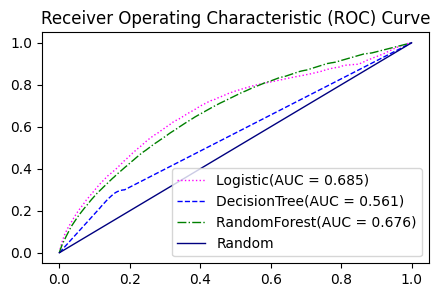

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(xval, yval, mdls, lbls):
    # Calculate ROC curve
    colors = [ 'magenta', 'blue', 'green']      # colors for visualization
    linestyles = [':', '--', '-.', '-', ]
     # Plot ROC curve
    plt.figure(figsize=(5, 3))
    for mdl, ls, lbl, clr in zip(mdls, linestyles, lbls, colors): 
        y_proba = mdl.predict_proba(xval)[:, 1]
        fpr, tpr, thresholds = roc_curve(yval, y_proba)
        # Calculate Area Under the Curve (AUC)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=clr, lw=1, linestyle=ls, label=f'{lbl}(AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='-', label='Random')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(valX, valY,models,labels)

In [17]:
# Memory optimization
# deleting unneeded items from RAM
del train
del trainX
del trainY
del valX
del valY 
del lr_clf
del dt_clf
del rf_clf
gc.collect()
    

1005

## General Performance
- Putting all we have done into perspective,we can test on different splits
- We can get an average of the performances and standard deviation and decide which model to go with.
- We will test with 5 extra splits

In [13]:
from numpy.random import randint
def get_split_performance(results):
    splits = list(set([randint(0, 15) for i in range(8)]))[:5]
    split_samples = [f"TrainingData-{i}" for i in splits]
    print(split_samples)
    for split_sample in split_samples:
        print(f"\n{'-'*10}{split_sample}{'-'*10}")
        df = pd.read_parquet(f"/kaggle/working/parquets/{split_sample}/")
        df = format_date(df)
        train, val = compute_ctr_train_val(df)
        trainX,trainY, valX, valY = split_train_val(train, val)
        trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)
        dt_clf = DecisionTreeClassifier(random_state=42)
        rf_clf = RandomForestClassifier(random_state=42)
        lr_clf = LogisticRegression()
        labels = ['Logistic','DecisionTree', 'RandomForest']
        models = [lr_clf, dt_clf, rf_clf]
        res = fit_models(labels, models, trainX, trainY, valX, valY)
        res['sample_name'] = split_sample
        results = pd.concat([results,res], ignore_index = True)
        del df
        del train
        del val
        del trainX
        del trainY
        del valX
        del valY
        gc.collect()
    return results,splits
result,splits = get_split_performance(results)
result

['TrainingData-4', 'TrainingData-7', 'TrainingData-9', 'TrainingData-10', 'TrainingData-14']

----------TrainingData-4----------
Train size: 1,121,456   Val size: 480,624
Trainig shape::  X: (1121456, 23), Y: (1121456,)
Validation shape::  X:(480624, 23), Y: (480624,)
(1121456, 62)
(480624, 62)
. . . 
----------TrainingData-7----------
Train size: 1,119,022   Val size: 479,581
Trainig shape::  X: (1119022, 23), Y: (1119022,)
Validation shape::  X:(479581, 23), Y: (479581,)
(1119022, 62)
(479581, 62)
. . . 
----------TrainingData-9----------
Train size: 1,120,410   Val size: 480,176
Trainig shape::  X: (1120410, 23), Y: (1120410,)
Validation shape::  X:(480176, 23), Y: (480176,)
(1120410, 62)
(480176, 62)
. . . 
----------TrainingData-10----------
Train size: 1,120,641   Val size: 480,275
Trainig shape::  X: (1120641, 23), Y: (1120641,)
Validation shape::  X:(480275, 23), Y: (480275,)
(1120641, 62)
(480275, 62)
. . . 
----------TrainingData-14----------
Train size: 1,119,556   Val size:

,models,log_loss,sample_name
0,Logistic,0.4517,TrainingData-5
1,DecisionTree,7.2584,TrainingData-5
2,RandomForest,0.6834,TrainingData-5
3,Logistic,0.4519,TrainingData-4
4,DecisionTree,7.5503,TrainingData-4
5,RandomForest,0.6786,TrainingData-4
6,Logistic,0.4482,TrainingData-7
7,DecisionTree,7.8437,TrainingData-7
8,RandomForest,0.6807,TrainingData-7
9,Logistic,0.4492,TrainingData-9


In [14]:
# geting mean and std of the above results to see which model works best
result.groupby('models', as_index=False).agg({'log_loss':['mean','std']})

models  log_loss          
                     mean       std
0  DecisionTree  7.351183  0.295264
1      Logistic  0.450283  0.001599
2  RandomForest  0.674600  0.013705

### Feature selection
- Logistic has the smallest mean log loss and standard deviation
- We shall use it for the next stage
- We are going to perform a stepwise feature selection
- Use log loss as the metric of comparison

In [15]:
rand_ = randint(0, num_train_splits) 
df = pd.read_parquet(f"/kaggle/working/parquets/TrainingData-{rand_}/")
df = format_date(df)
train, val = compute_ctr_train_val(df)
trainX,trainY, valX, valY = split_train_val(train, val)
trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)

### FORWARD STEPWISE REGRESSION
model = LogisticRegression()
# Forward stepwise feature selection
features = trainX.columns
selected_features_forward = []
best_log_loss_forward = float('inf')

for feature in features:
    print('.',end='')
    X_train_temp = trainX[selected_features_forward + [feature]]
    X_val_temp   = valX[selected_features_forward + [feature]]
    model.fit(X_train_temp, trainY)
    proba = model.predict_proba(X_val_temp)
    log_loss_temp = log_loss(valY, proba)
    if abs(log_loss_temp) < abs(best_log_loss_forward):
        selected_features_forward.append(feature)
        best_log_loss_forward = log_loss_temp
print("\nSelected features (forward):", selected_features_forward)


del X_train_temp
del X_val_temp
del model
del proba
gc.collect()
### BACKWARD STEPWISE REGRESSION
model = LogisticRegression()
selected_features_backward = list(features)
best_log_loss_backward = float('inf')

for feature in reversed(features):
    print('.',end='')
    selected_features_backward.remove(feature)
    X_train_temp = trainX[selected_features_backward]
    X_val_temp   = valX[selected_features_backward]
    model.fit(X_train_temp, trainY)
    proba = model.predict_proba(X_val_temp)
    log_loss_temp = log_loss(valY, proba)
    if abs(log_loss_temp) < abs(best_log_loss_backward):
        best_log_loss_backward = log_loss_temp
    else:
        selected_features_backward.append(feature)
print("\nSelected features (backward):", selected_features_backward)

del df
del train
del val
del trainX
del trainY
del valX
del valY
del X_train_temp
del X_val_temp
del model
del proba
gc.collect()

Train size: 1,119,022   Val size: 479,581
Trainig shape::  X: (1119022, 23), Y: (1119022,)
Validation shape::  X:(479581, 23), Y: (479581,)
(1119022, 62)
(479581, 62)
..............................................................
Selected features (forward): ['C1_1002', 'C1_1005', 'C1_1007', 'C1_1008', 'C1_1010', 'C1_1012', 'banner_pos_1', 'banner_pos_2', 'banner_pos_4', 'banner_pos_5', 'banner_pos_7', 'device_type_5', 'device_conn_type_2', 'device_conn_type_3', 'device_conn_type_5', 'C15_216', 'C15_300', 'C15_320', 'C15_480', 'C15_728', 'C16_50', 'C16_90', 'C16_250', 'C16_480', 'C18_1', 'C18_2', 'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6', 'time_of_day_ctr', 'site_id_ctr', 'site_domain_ctr', 'site_category_ctr', 'app_id_ctr', 'app_domain_ctr', 'app_category_ctr', 'device_model_ctr', 'C21_ctr']
..............................................................
Selected features (backward): ['C20_ctr', 'C19_ctr', 'C17_ctr', 'C14_ctr', 'device_model_ctr

NameError: name 'ValY' is not defined

In [18]:
# For the chosen list of features in each stepwise approach
# we are going to test with 5 samples to get a more general performance

def choose_stepwise_approach(trainX, trainY, valX, valY):
    # forward features
    model = LogisticRegression()
    model.fit(trainX[selected_features_forward], trainY)
    probabilities = model.predict_proba(valX[selected_features_forward])
    fwd_stepwise = round(log_loss(valY, probabilities),5)

    # backward features
    model = LogisticRegression()
    model.fit(trainX[selected_features_backward], trainY)
    probabilities = model.predict_proba(valX[selected_features_backward])
    bwd_stepwise = round(log_loss(valY, probabilities),5)
    del probabilities
    del model
    gc.collect()
    return [fwd_stepwise, bwd_stepwise]


splits = list(set([randint(0, num_train_splits) for i in range(num_train_splits)]))[:5]
split_samples = [f"TrainingData-{i}" for i in splits]
print(split_samples)
fwd = []
bwd = []
for split_sample in split_samples:
    print(f"\n{'-'*10}{split_sample}{'-'*10}")
    df = pd.read_parquet(f"/kaggle/working/parquets/{split_sample}/")
    df = format_date(df)
    train, val = compute_ctr_train_val(df)
    trainX,trainY, valX, valY = split_train_val(train, val)
    trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)
    stp = choose_stepwise_approach(trainX,trainY, valX, valY)
    fwd.append(stp[0])
    bwd.append(stp[1])

del df
del train
del val
del trainX
del trainY
del valX
del valY
gc.collect()


['TrainingData-2', 'TrainingData-3', 'TrainingData-4', 'TrainingData-5', 'TrainingData-7']

----------TrainingData-2----------
Train size: 1,118,577   Val size: 479,391
Trainig shape::  X: (1118577, 23), Y: (1118577,)
Validation shape::  X:(479391, 23), Y: (479391,)
(1118577, 62)
(479391, 62)

----------TrainingData-3----------
Train size: 1,119,957   Val size: 479,982
Trainig shape::  X: (1119957, 23), Y: (1119957,)
Validation shape::  X:(479982, 23), Y: (479982,)
(1119957, 62)
(479982, 62)

----------TrainingData-4----------
Train size: 1,121,456   Val size: 480,624
Trainig shape::  X: (1121456, 23), Y: (1121456,)
Validation shape::  X:(480624, 23), Y: (480624,)
(1121456, 62)
(480624, 62)

----------TrainingData-5----------
Train size: 1,118,816   Val size: 479,493
Trainig shape::  X: (1118816, 23), Y: (1118816,)
Validation shape::  X:(479493, 23), Y: (479493,)
(1118816, 62)
(479493, 62)

----------TrainingData-7----------
Train size: 1,119,022   Val size: 479,581
Trainig shape::  X:

39

In [19]:
stp = pd.DataFrame({'forward': fwd, 'backward': bwd})
print(f"MEAN:: Fwd:{stp.forward.mean():.5f}, Bwd:{stp.backward.mean():.5f}")
print(f" STD:: Fwd:{stp.forward.std():.5f}, Bwd:{stp.backward.std():.5f}")
print(f" MIN:: Fwd:{stp.forward.min():.5f}, Bwd:{stp.backward.min():.5f}")
print()
stp

MEAN:: Fwd:0.38937, Bwd:0.39300
 STD:: Fwd:0.00160, Bwd:0.00123
 MIN:: Fwd:0.38754, Bwd:0.39139



,forward,backward
0,0.38773,0.39139
1,0.39057,0.39405
2,0.39019,0.39379
3,0.39082,0.39381
4,0.38754,0.39196


In [18]:
selected_features = ['C1_1002', 'C1_1005', 'C1_1007', 'C1_1008', 'C1_1010', 'C1_1012', 'banner_pos_1', 
                     'banner_pos_2', 'banner_pos_4', 'banner_pos_5', 'banner_pos_7', 'device_type_5', 
                     'device_conn_type_2', 'device_conn_type_3', 'device_conn_type_5', 'C15_216', 'C15_300', 
                     'C15_320', 'C15_480', 'C15_728', 'C16_50', 'C16_90', 'C16_250', 'C16_480', 'C18_1', 
                     'C18_2', 'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 
                     'week_day_6', 'time_of_day_ctr', 'site_id_ctr', 'site_domain_ctr', 'site_category_ctr', 
                     'app_id_ctr', 'app_domain_ctr', 'app_category_ctr', 'device_model_ctr', 'C21_ctr']

Train size: 1,118,999   Val size: 479,572
Trainig shape::  X: (1118999, 23), Y: (1118999,)
Validation shape::  X:(479572, 23), Y: (479572,)
(1118999, 62)
(479572, 62)


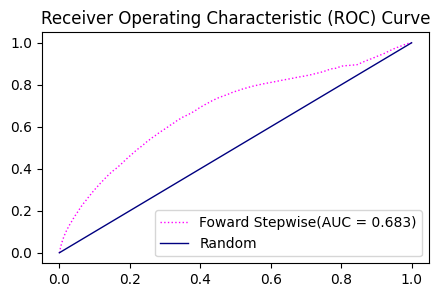

In [15]:
selected_features = selected_features_forward
rand_ = randint(0, num_train_splits) 
df = pd.read_parquet(f"/kaggle/working/parquets/TrainingData-{rand_}/")
df = format_date(df)
train, val = compute_ctr_train_val(df)
trainX,trainY, valX, valY = split_train_val(train, val)
trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)
lr = LogisticRegression()
lr.fit(trainX,trainY)
plot_roc_curve(valX, valY,[lr],['Foward Stepwise'])

In [19]:
del df
del train
del val
del trainX
del trainY
del valX
del valY
del lr
gc.collect()

0

- Forward selection is better, we shall proceed with columns of forward selection
- We are going to fit a neural network to compare with the Logistic
- We shall test with 5 files

In [21]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

def run_neural_network(split_file):
    print(f"\n{'-'*10}{split_file}{'-'*10}")
    df = pd.read_parquet(f"/kaggle/working/parquets/{split_sample}/")
    df = format_date(df)
    train, val = compute_ctr_train_val(df)
    trainX,trainY, valX, valY = split_train_val(train, val)
    trainX, valX = one_hot_encode(trainX, valX, cols_to_encode)
    trainX, valX = trainX[selected_features], valX[selected_features]
    NEpochs = 200
    BatchSize=20000
    Optimizer=optimizers.RMSprop(learning_rate=0.001)
    TrXrsc = (trainX - trainX.min(axis=0))/(trainX.max(axis=0)-trainX.min(axis=0))
    print(TrXrsc.shape)
    # ------------------------------------------
    # Rescale the validation data
    ValXrsc = (valX - trainX.min(axis=0))/(trainX.max(axis=0)-trainX.min(axis=0))
    print(ValXrsc.shape)
    adsNN = Sequential()
    adsNN.add(Dense(units=100,input_shape=(TrXrsc.shape[1],),activation="relu",use_bias=True))
    adsNN.add(Dense(units=200,activation="relu",use_bias=True))
    adsNN.add(Dense(units=300,activation="relu",use_bias=True))
    adsNN.add(Dense(units=200,activation="relu",use_bias=True))
    adsNN.add(Dense(units=100,activation="relu",use_bias=True))
    adsNN.add(Dense(units=50,activation="relu",use_bias=True))
    adsNN.add(Dense(units=1,activation="sigmoid",use_bias=False))
    adsNN.compile(loss='binary_crossentropy', optimizer=Optimizer,metrics=['binary_crossentropy','accuracy'])
    StopRule = EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=500,min_delta=0.0)
    FitHist = (adsNN.fit(TrXrsc,trainY,validation_data=(ValXrsc,valY), 
                        epochs=NEpochs,batch_size=BatchSize,verbose=0, 
                        callbacks=[StopRule]))
    loglos = FitHist.history['val_loss'][-1]
    # recover memmory
    del adsNN
    del train
    del val
    del trainX
    del trainY
    del valX
    del valY
    del TrXrsc
    del ValXrsc
    gc.collect()
    return loglos


In [22]:
splits = list(set([randint(0, num_train_splits) for i in range(num_train_splits)]))[:5]
split_samples = [f"TrainingData-{i}" for i in splits]
logloss = []
for split_sample in split_samples:
    loglos = run_neural_network(split_sample) 
    logloss.append(loglos)


----------TrainingData-1----------
Train size: 1,120,373   Val size: 480,160
Trainig shape::  X: (1120373, 23), Y: (1120373,)
Validation shape::  X:(480160, 23), Y: (480160,)
(1120373, 62)
(480160, 62)
(1120373, 41)
(480160, 41)

----------TrainingData-3----------
Train size: 1,119,957   Val size: 479,982
Trainig shape::  X: (1119957, 23), Y: (1119957,)
Validation shape::  X:(479982, 23), Y: (479982,)
(1119957, 62)
(479982, 62)
(1119957, 41)
(479982, 41)

----------TrainingData-4----------
Train size: 1,121,456   Val size: 480,624
Trainig shape::  X: (1121456, 23), Y: (1121456,)
Validation shape::  X:(480624, 23), Y: (480624,)
(1121456, 62)
(480624, 62)
(1121456, 41)
(480624, 41)

----------TrainingData-5----------
Train size: 1,118,816   Val size: 479,493
Trainig shape::  X: (1118816, 23), Y: (1118816,)
Validation shape::  X:(479493, 23), Y: (479493,)
(1118816, 62)
(479493, 62)
(1118816, 41)
(479493, 41)

----------TrainingData-6----------
Train size: 1,119,350   Val size: 479,722
Tr

In [23]:
import numpy as np
# Looking at returned log loss
print(f"Mean:{np.mean(logloss):.5f}")
print(f"Std:{np.std(logloss):.5f}")


Mean:0.39305
Std:0.00152


In [28]:
gc.collect()

3879

- We see that Logistic resgression is still the best model even when compared to the Neural Network
- We are going to use Logistic regression to make the predictions.
- Now the test dataset is big, ~13 million records.
    - Just like we did for the train set
    - Split the test set into portions of 1%
    - For each test split
    - Use 5 train splits to make predictions 
    - Do a majority voting based on the binary prediction
    - Make a probability average for the probabilities of the average class 
    - This is implemented in method `get_predict_proba` the next cell

In [38]:
from collections import Counter
import numpy as np
def get_predict_proba(arr):
    arr = list(arr)
    majority_class = np.argmax(arr, axis=1)
    c = Counter(majority_class)
    most_ = c.most_common(1)[0][0]
    # Find the indices where the majority class is True
    indices_majority_class = np.where(majority_class == most_)[0]
    vals = [arr[i] for i in indices_majority_class]
    positive_class = [vals[i][1] for i in range(len(vals))]
    return round(np.mean(positive_class),10)

In [21]:
test = pd.read_parquet('/kaggle/input/ai-and-ml-project/parquets/ProjectTestData/')
num_test_splits = 5
split_size = int(len(test)/num_test_splits)
test1 = test.iloc[:split_size]
test2 = test.iloc[split_size:split_size*2]
test3 = test.iloc[split_size*2:split_size*3]
test4 = test.iloc[split_size*3:split_size*4]
test5 = test.iloc[split_size*4:]

del test
gc.collect()

0

In [51]:
test = pd.read_parquet('/kaggle/input/ai-and-ml-project/parquets/ProjectTestData/')
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3295858251275419735,14102809,1005,1,85f751fd,c4e18dd6,50e219e0,1dc72b4d,2347f47a,0f2161f8,cd915ca3,834cff24,0d8ce284,1,0,8334,300,50,761,3,175,100075,23
1,12281702837842634283,14103120,1007,0,85f751fd,c4e18dd6,50e219e0,8311368f,1dc9b529,0f2161f8,ec0aff16,6f6d6456,6fe5a545,1,2,24303,320,50,2788,3,295,100194,240
2,4638380339534007785,14103109,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,bd807c39,a2f15940,1,0,24165,320,50,2776,0,35,-1,79
3,17039804736879076347,14103101,1002,0,48c42b43,de0f0f82,50e219e0,ecad2386,7801e8d9,07d7df22,dfb9b781,5ce9f91d,a0215413,0,0,23438,320,50,2684,2,1327,-1,52
4,5753064066292192109,14103119,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0da60c14,5096d134,1,0,24084,320,50,2761,2,35,100148,13


In [54]:
num_test_splits = 5
split_size = int(len(test)/num_test_splits)
test1 = test.iloc[:split_size]
test1.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3295858251275419735,14102809,1005,1,85f751fd,c4e18dd6,50e219e0,1dc72b4d,2347f47a,0f2161f8,cd915ca3,834cff24,0d8ce284,1,0,8334,300,50,761,3,175,100075,23
1,12281702837842634283,14103120,1007,0,85f751fd,c4e18dd6,50e219e0,8311368f,1dc9b529,0f2161f8,ec0aff16,6f6d6456,6fe5a545,1,2,24303,320,50,2788,3,295,100194,240
2,4638380339534007785,14103109,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,bd807c39,a2f15940,1,0,24165,320,50,2776,0,35,-1,79
3,17039804736879076347,14103101,1002,0,48c42b43,de0f0f82,50e219e0,ecad2386,7801e8d9,07d7df22,dfb9b781,5ce9f91d,a0215413,0,0,23438,320,50,2684,2,1327,-1,52
4,5753064066292192109,14103119,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0da60c14,5096d134,1,0,24084,320,50,2761,2,35,100148,13


In [55]:
test2.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,week_day,month_day,time_of_day
2962642,1418784414891018128,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,f267f6a4,a4b6f65b,1,0,20508,320,50,2351,3,163,-1,61,1,21,0
4132938,17369513258572896328,2014-10-21,1005,0,d6f0c11f,a8546a2d,335d28a8,ecad2386,7801e8d9,07d7df22,a99f214a,4e225992,779d90c2,1,0,18993,320,50,2161,0,35,-1,157,1,21,0
3782685,1819243481749917401,2014-10-21,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,8d4a8028,6e1e2240,1,0,19950,320,50,1800,3,167,-1,23,1,21,0
4813553,10408083230449973220,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,f20dbae2,c6263d8a,1,0,15701,320,50,1722,0,35,-1,79,1,21,0
3625046,9431984924323935492,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,7e3739ea,ecb851b2,1,0,15706,320,50,1722,0,35,100084,79,1,21,0


In [23]:
len(test1) + len(test2) + len(test3) + len(test4) + len(test5)

13015341

In [24]:
splits = list(set([randint(0, num_train_splits) for i in range(num_train_splits)]))[:10]
split_samples = [f"TrainingData-{i}" for i in splits]
a = 0
b = 2
final_df = pd.DataFrame()
for i in range(0,10,2):   
    train_set = split_samples[a:a+b]
    train_split1 = pd.read_parquet(f"/kaggle/working/parquets/{train_set[0]}/")
    train_split2 = pd.read_parquet(f"/kaggle/working/parquets/{train_set[1]}/")
    model_trained=False
    print(f"\n{'-'*20}{train_set[0]} and {train_set[1]}{'-'*20}")
    train_dataframe_probs = pd.DataFrame()
    j = 1
    for test_set in [test1, test2, test3, test4, test5]:
        test_dt_  = pd.DataFrame()
        train_set = pd.concat([train_split1,train_split2], ignore_index=False)
        train_set = format_date(train_set)
        print(f"\n{'-'*10}TestDataSplit-{j}{'-'*10}")
        test_set  = format_date(test_set)
        test_dt_['test_ids']  = test_set['id']
        train_set, test_set   = compute_ctr(train_set,test_set)
        train_setX,train_setY, test_setX=split_train_val(train_set, test_set)
        train_setX, test_setX = one_hot_encode(train_setX, test_setX)
        train_setX, test_setX = train_setX[selected_features], test_setX[selected_features]
        if not model_trained:
            model = LogisticRegression()
            model.fit(train_setX, train_setY)
            model_trained = True
        probabilities = model.predict_proba(test_setX)
        probabilities = [(i) for i in probabilities]
        test_dt_[f'probabilities-{i}'] = probabilities
        train_dataframe_probs = pd.concat([train_dataframe_probs, test_dt_], ignore_index=True)
        del test_setX
        del test_set
        j += 1
    if len(final_df) == 0:
        final_df = pd.concat([final_df, train_dataframe_probs], ignore_index=True)
    else:
        final_df[f'probabilities-{i}'] = train_dataframe_probs[f'probabilities-{i}'] 
    del train_setX
    del train_setY
    del train_set 
    del model
    del train_split1
    del train_split2
    del train_dataframe_probs
    gc.collect()
    a+=b
print(split_samples)


--------------------TrainingData-1 and TrainingData-2--------------------

----------TestDataSplit-1----------
Trainig shape::  X: (3199767, 23), Y: (3199767,)
Validation shape::  X:(2603068, 23)
(3199767, 65)
(2603068, 65)

----------TestDataSplit-2----------
Trainig shape::  X: (3199767, 23), Y: (3199767,)
Validation shape::  X:(2603068, 23)
(3199767, 65)
(2603068, 65)

----------TestDataSplit-3----------
Trainig shape::  X: (3199767, 23), Y: (3199767,)
Validation shape::  X:(2603068, 23)
(3199767, 65)
(2603068, 65)

----------TestDataSplit-4----------
Trainig shape::  X: (3199767, 23), Y: (3199767,)
Validation shape::  X:(2603068, 23)
(3199767, 65)
(2603068, 65)

----------TestDataSplit-5----------
Trainig shape::  X: (3199767, 23), Y: (3199767,)
Validation shape::  X:(2603069, 23)
(3199767, 65)
(2603069, 65)

--------------------TrainingData-3 and TrainingData-4--------------------

----------TestDataSplit-1----------
Trainig shape::  X: (3197733, 23), Y: (3197733,)
Validation sha

In [26]:
del test_dt_
gc.collect()

486

In [27]:
final_df.head()

,test_ids,probabilities-0,probabilities-2,probabilities-4,probabilities-6,probabilities-8
0,1437079882499273251,"[0.8346997326256393, 0.16530026737436065]","[0.8333408807074234, 0.16665911929257654]","[0.8339021723848457, 0.16609782761515435]","[0.8341547788342727, 0.16584522116572728]","[0.8329475634372604, 0.16705243656273958]"
1,418748851948781850,"[0.9050452725498879, 0.09495472745011212]","[0.9057432548070528, 0.09425674519294726]","[0.7815202517741926, 0.21847974822580743]","[0.9002928628736703, 0.09970713712632974]","[0.9345821064917332, 0.06541789350826678]"
2,5014726220736468617,"[0.7597831039389, 0.2402168960611]","[0.9007380233790757, 0.09926197662092426]","[0.9469523117131265, 0.05304768828687346]","[0.9267342792966694, 0.07326572070333058]","[0.9467720471833825, 0.053227952816617526]"
3,11368704976105012416,"[0.9337217606626926, 0.06627823933730734]","[0.9255035256950518, 0.07449647430494818]","[0.9455984493750932, 0.05440155062490685]","[0.7955548538876787, 0.20444514611232134]","[0.8856913751174846, 0.11430862488251531]"
4,2612438020262547705,"[0.9462044591176436, 0.05379554088235642]","[0.7947604029782515, 0.20523959702174852]","[0.8877501109372485, 0.11224988906275148]","[0.7984900337369472, 0.20150996626305284]","[0.819106237026777, 0.18089376297322302]"


In [44]:
final_df2 = final_df.sample(1000)
final_df2['probabilities'] = list(final_df2.iloc[:,1:].values)
final_df2 = final_df2.drop(['probabilities-0', 'probabilities-2', 'probabilities-4', 'probabilities-6', 'probabilities-8'], axis = 1)
final_df2.head()

,test_ids,probabilities
6592698,7033605526362708362,"[[0.9341719672330753, 0.06582803276692475], [0..."
11171470,9369105289195317798,"[[0.9670560348005646, 0.03294396519943549], [0..."
1790618,4856193829398608455,"[[0.9516003706388869, 0.048399629361113104], [..."
8322857,3940742139174351926,"[[0.8286276903949339, 0.17137230960506608], [0..."
2308864,12104787795667642061,"[[0.8968297529352988, 0.10317024706470125], [0..."


In [46]:
final_df2 = final_df.copy()
final_df2['probabilities'] = list(final_df2.iloc[:,1:].values)
final_df2 = final_df2.drop(['probabilities-0', 'probabilities-2', 'probabilities-4', 'probabilities-6', 'probabilities-8'], axis = 1)


In [48]:
final_df2['pos_probabilities'] = final_df2['probabilities'].apply(get_predict_proba)
final_df2.head()


,test_ids,probabilities,pos_probabilities
0,1437079882499273251,"[[0.8346997326256393, 0.16530026737436065], [0...",0.166191
1,418748851948781850,"[[0.9050452725498879, 0.09495472745011212], [0...",0.114563
2,5014726220736468617,"[[0.7597831039389, 0.2402168960611], [0.900738...",0.103804
3,11368704976105012416,"[[0.9337217606626926, 0.06627823933730734], [0...",0.102786
4,2612438020262547705,"[[0.9462044591176436, 0.05379554088235642], [0...",0.150738


In [60]:
final_df2.columns = ['id', 'P(click)']
final_df2.to_csv('/kaggle/working/ProjectSubmission.csv', index=False)
print(len(final_df2))

13015341